Accuracy: 0.833870720098265
              precision    recall  f1-score   support

           0       0.95      0.82      0.88      4942
           1       0.61      0.86      0.71      1571

    accuracy                           0.83      6513
   macro avg       0.78      0.84      0.80      6513
weighted avg       0.87      0.83      0.84      6513



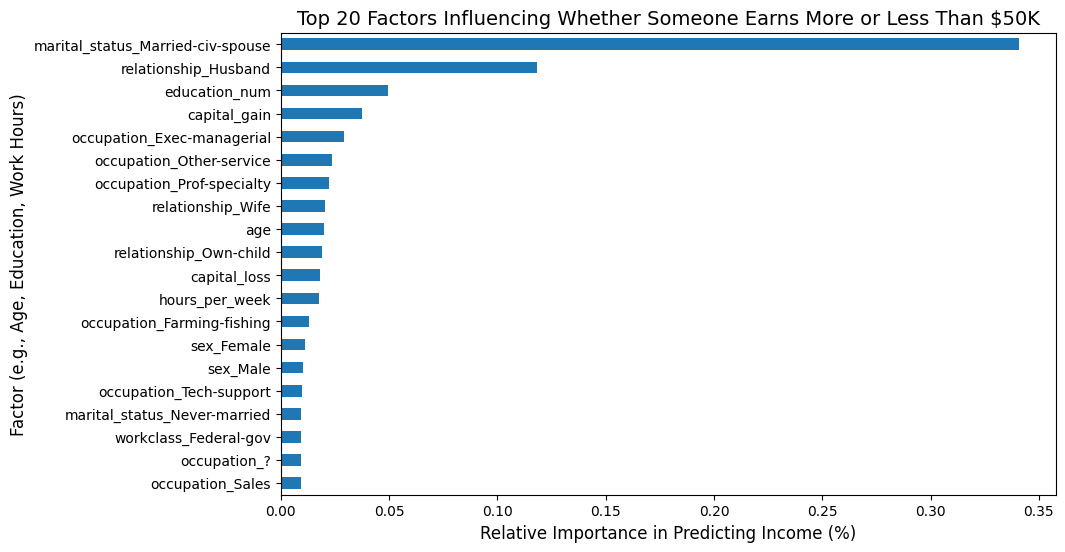

In [5]:
# -------------------------------
# Adult Income Prediction Notebook
# -------------------------------

# Imports
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# -------------------------------
# 1. Load dataset
# -------------------------------
column_names = [
    "age", "workclass", "fnlwgt", "education", "education_num", "marital_status",
    "occupation", "relationship", "race", "sex", "capital_gain", "capital_loss",
    "hours_per_week", "native_country", "income"
]

df = pd.read_csv('adult.data', names=column_names, sep=",", skipinitialspace=True)

# -------------------------------
# 2. Handle missing values
# -------------------------------
for col in ['workclass', 'occupation', 'native_country']:
    df[col].fillna(df[col].mode()[0], inplace=True)

# -------------------------------
# 3. Separate features and target
# -------------------------------
X = df.drop('income', axis=1)
y = df['income'].apply(lambda x: 1 if x.strip() == '>50K' else 0)

# -------------------------------
# 4. One-hot encode categorical variables
# -------------------------------
X = pd.get_dummies(X)

# Save column names for later API alignment
train_columns = X.columns.tolist()
joblib.dump(train_columns, "train_columns.pkl")

# -------------------------------
# 5. Split into train/test sets
# -------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# -------------------------------
# 6. Train XGBoost
# -------------------------------
xgb_tuned = XGBClassifier(
    n_estimators=200,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=3,
    random_state=42,
    eval_metric='logloss'
)

xgb_tuned.fit(X_train, y_train)

# Save trained model
joblib.dump(xgb_tuned, "xgb_tuned_model.pkl")

# -------------------------------
# 7. Evaluate
# -------------------------------
y_pred = xgb_tuned.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred))

# -------------------------------
# 8. Feature importances
# -------------------------------
importances = xgb_tuned.feature_importances_
feature_importance = pd.Series(importances, index=X_train.columns).sort_values(ascending=False)

plt.figure(figsize=(10,6))
feature_importance.head(20).plot(kind='barh')
plt.gca().invert_yaxis()
plt.title("Top 20 Factors Influencing Whether Someone Earns More or Less Than $50K", fontsize=14)
plt.xlabel("Relative Importance in Predicting Income (%)", fontsize=12)
plt.ylabel("Factor (e.g., Age, Education, Work Hours)", fontsize=12)
plt.show()
